In [1]:
import pandas as pd

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [2]:
import numpy as np

embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
import umap

n_neighbors = 50
min_dist = 1
n_components = 218

reduced_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(embeddings)

## Density-based clustering

### HDBSCAN

Parameters:

min_samples: 

min_cluster_size: smallest group to be considered a cluster


!! Too many clusters to compare, clusters make sense in itself, noisy comments are not just comments that have one word

In [50]:
import hdbscan

labels = hdbscan.HDBSCAN(
    min_cluster_size=30,
).fit_predict(reduced_embeddings)

In [51]:
data['labels_hdbscan'] = labels

In [59]:
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies_chart= frequencies[frequencies[:,0].argsort()]

frequencies_chart

array([[   -1, 10996],
       [    0,    74],
       [    1,    84],
       [    2,    94],
       [    3,   139],
       [    4,    33],
       [    5,   230],
       [    6,   173],
       [    7,   312],
       [    8,    33],
       [    9,   201],
       [   10,   132],
       [   11,    77],
       [   12,   180],
       [   13,    83],
       [   14,   789],
       [   15,    49],
       [   16,    41],
       [   17,    59],
       [   18,    36],
       [   19,    49],
       [   20,    80],
       [   21,    43],
       [   22,    91],
       [   23,    99],
       [   24,    79],
       [   25,   105],
       [   26,   100],
       [   27,   144],
       [   28,   188],
       [   29,    49],
       [   30,    59],
       [   31,   253],
       [   32,   190],
       [   33,    55],
       [   34,    32],
       [   35,    90],
       [   36,    62],
       [   37,    94],
       [   38,    72],
       [   39,    44],
       [   40,   147],
       [   41,   222],
       [   

<BarContainer object of 115 artists>

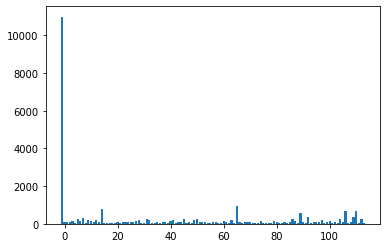

In [54]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(15,10))
plt.bar(frequencies[:,0], frequencies[:,1])

In [55]:
n_neighbors = 50
min_dist = 0.1
n_components = 2

d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(reduced_embeddings)

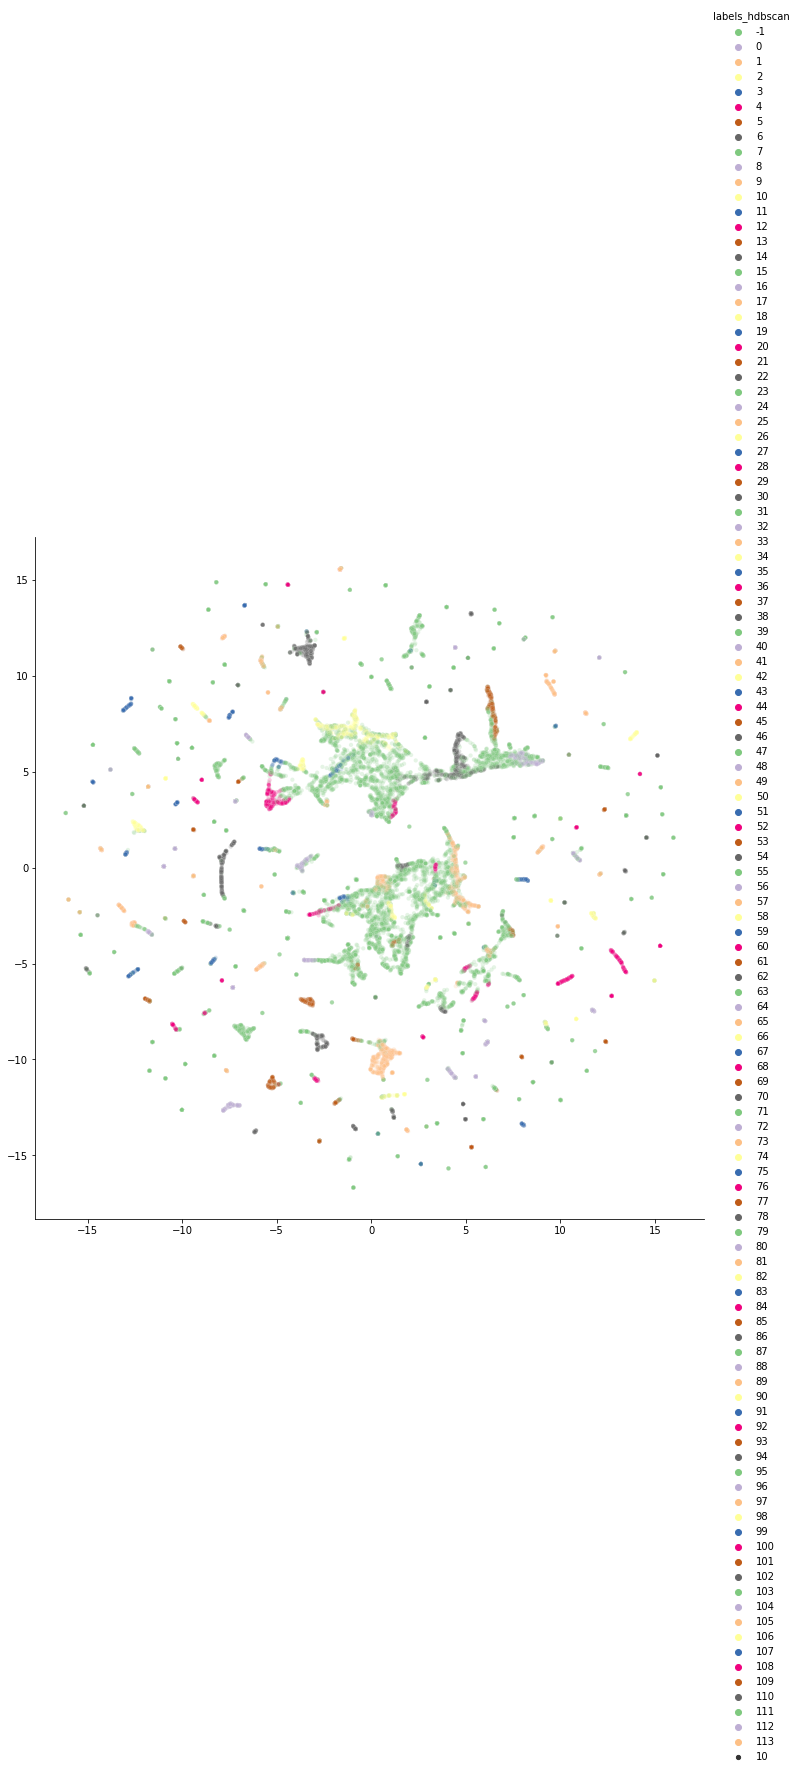

In [57]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["labels_hdbscan"], palette = palette_param,alpha = alpha_param,height = 10)

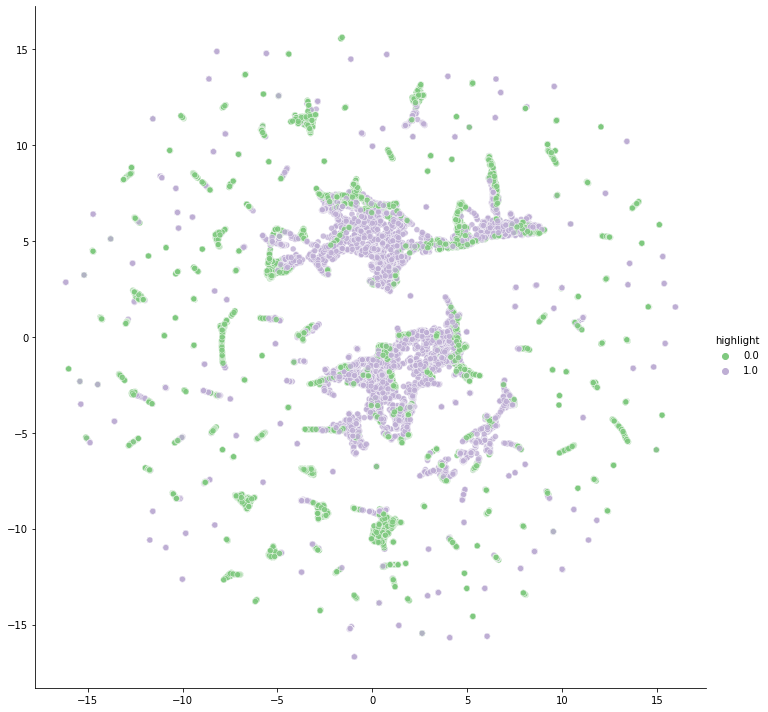

In [60]:
## Choose a cluster to higlight:
cluster_num = -1
data['highlight'] = np.zeros(len(data.index))
data.loc[data['labels_hdbscan'] == cluster_num, 'highlight'] = 1

sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [63]:
# Choose a cluster to print
cluster_number =   57
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['labels_hdbscan'] = data['labels_hdbscan'].astype('category')
cluster = data[data['labels_hdbscan']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster

Number of samples in the cluster: 74


,publishedAt,authorName,text,isReply,cleaned,labels_hdbscan,highlight
333,2019-11-17 01:42:31,Moose boy,yall forgot Canada again\n\n,0,yall forgot again\n\n,57,0.0
362,2019-11-15 09:32:59,Marvin Gershowitz,cheech and chong! \n**_WOW_**\n\n,0,cheech and chong! \n**_WOW_**\n\n,57,0.0
944,2019-09-03 02:44:58,Susan Jane,You forgot to show Antarctica\n\n,0,You forgot to show Antarctica\n\n,57,0.0
1256,2019-10-25 18:57:22,George Fares,Forgot Florida\n\n,1,Forgot Florida\n\n,57,0.0
1438,2019-06-29 10:55:02,Vietnam Ball,you forgot the city of manila\n\n,0,you forgot the city of manila\n\n,57,0.0
...,...,...,...,...,...,...,...
22670,2016-02-08 11:52:52,Gregg The Mapper,You forgot Canada... 😱. \nHello 'Mericans we'...,0,You forgot ... 😱. \nHello 'Mericans we're her...,57,0.0
22805,2016-02-01 17:11:32,FrostRC :/,"You forgot Canada, you twit....\n\n",0,"You forgot , you twit....\n\n",57,0.0
22889,2016-01-28 16:22:33,Sir Winston Churchill,You forgot Canada and South Africa\n\n,0,You forgot and Africa\n\n,57,0.0
24020,2016-01-26 08:08:26,raph,+Jen dont forget nz!!\n\n,1,+Jen dont forget nz!!\n\n,57,0.0
